## Tutorial 21 - Payload Range Diagram
Welcome to this tutorial on creating a payload range diagram of a turbofan aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## 1. Header and Imports


The **Imports** section is divided into two parts: general-purpose Python libraries and simulation-specific libraries.

In [5]:
import numpy as np  
from copy import deepcopy   
import matplotlib.pyplot as plt   
import os

## 2. RCAIDE Imports

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.

### Key Imports:

1. **RCAIDE**: The core package is imported directly. This approach allows us to access specific classes and methods from RCAIDE without repeatedly importing individual components at the top of the script.

2. **`Units` Module**: The Units module is a standardized way to handle unit conversions within RCAIDE. It ensures consistent units across all inputs and outputs, reducing the likelihood of conversion errors.

3. **design_turbofan**, **wing_planform**, **segment_properties** : These functions are used in designing the vehicle to size the engines based on certain parameters, and create geometry.

4. **compute_payload_range_diagram** : This function is used to compute the payload range diagram of the aircraft. It accepts inputs of the vehicle and analysis conditions and returns a payload range diagram.


In [6]:
import RCAIDE
from RCAIDE.Framework.Core import Units , Container 
from RCAIDE.Library.Methods.Propulsors.Turbofan_Propulsor               import design_turbofan 
from RCAIDE.Library.Methods.Geometry.Planform                           import wing_planform, segment_properties
from RCAIDE.Library.Methods.Performance.compute_payload_range_diagram   import compute_payload_range_diagram
from RCAIDE.Library.Plots                 import *     

## 3. Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

A detailed description of the vehicle setup is provided in the [Tutorial 1](tutorial_01_turbofan_aircraft.ipynb).

In [7]:

# ----------------------------------------------------------------------------------------------------------------------
#   Build the Vehicle
# ----------------------------------------------------------------------------------------------------------------------
def vehicle_setup():
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ################################################# Vehicle-level Properties ########################################################  
    #------------------------------------------------------------------------------------------------------------------------------------
    vehicle = RCAIDE.Vehicle()
    vehicle.tag = 'Embraer_E190AR'
 
    # mass properties (http://www.embraercommercialaviation.com/AircraftPDF/E190_Weights.pdf)
    vehicle.mass_properties.max_takeoff               = 51800.   # kg
    vehicle.mass_properties.operating_empty           = 27837.   # kg
    vehicle.mass_properties.takeoff                   = 51800.   # kg
    vehicle.mass_properties.max_zero_fuel             = 40900.   # kg
    vehicle.mass_properties.max_payload               = 13063.   # kg
    vehicle.mass_properties.max_fuel                  = 12971.   # kg
    vehicle.mass_properties.cargo                     = 0.0  # kg

    vehicle.mass_properties.center_of_gravity         = [[16.8, 0, 1.6]]
    vehicle.mass_properties.moments_of_inertia.tensor = [[10 ** 5, 0, 0],[0, 10 ** 6, 0,],[0,0, 10 ** 7]] 

    # envelope properties
    vehicle.flight_envelope.ultimate_load             = 3.5
    vehicle.flight_envelope.positive_limit_load       = 1.5

    # basic parameters
    vehicle.reference_area                            = 92.
    vehicle.passengers                                = 106
    vehicle.systems.control                           = "fully powered"
    vehicle.systems.accessories                       = "medium range"


    #------------------------------------------------------------------------------------------------------------------------------------
    # ######################################################## Wings ####################################################################  
    #------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------
    wing                         = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                     = 'main_wing'
    wing.areas.reference         = 92.0
    wing.aspect_ratio            = 8.4
    wing.chords.root             = 6.2
    wing.chords.tip              = 1.44
    wing.sweeps.quarter_chord    = 23.0 * Units.deg
    wing.thickness_to_chord      = 0.11
    wing.taper                   = 0.28
    wing.dihedral                = 5.00 * Units.deg
    wing.spans.projected         = 28.72
    wing.origin                  = [[13.0,0,-1.]]
    wing.vertical                = False
    wing.symmetric               = True       
    wing.high_lift               = True
    wing.areas.exposed           = 0.80 * wing.areas.wetted        
    wing.twists.root             = 2.0 * Units.degrees
    wing.twists.tip              = 0.0 * Units.degrees    
    wing.dynamic_pressure_ratio  = 1.0
    
    
    segment = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'root'
    segment.percent_span_location = 0.0
    segment.twist                 = 4. * Units.deg
    segment.root_chord_percent    = 1.
    segment.thickness_to_chord    = .11
    segment.dihedral_outboard     = 5. * Units.degrees
    segment.sweeps.quarter_chord  = 20.6 * Units.degrees
    wing.append_segment(segment)    
    
    segment = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'yehudi'
    segment.percent_span_location = 0.348
    segment.twist                 = (4. - segment.percent_span_location*4.) * Units.deg
    segment.root_chord_percent    = 0.60
    segment.thickness_to_chord    = .11
    segment.dihedral_outboard     = 4 * Units.degrees
    segment.sweeps.quarter_chord  = 24.1 * Units.degrees
    wing.append_segment(segment)
    
    segment = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'section_2'
    segment.percent_span_location = 0.961
    segment.twist                 = (4. - segment.percent_span_location*4.) * Units.deg
    segment.root_chord_percent    = 0.25
    segment.thickness_to_chord    = .11
    segment.dihedral_outboard     = 70. * Units.degrees
    segment.sweeps.quarter_chord  = 40. * Units.degrees
    wing.append_segment(segment)

    segment = RCAIDE.Library.Components.Wings.Segments.Segment() 
    segment.tag                   = 'Tip'
    segment.percent_span_location = 1.
    segment.twist                 = (4. - segment.percent_span_location*4.) * Units.deg
    segment.root_chord_percent    = 0.070
    segment.thickness_to_chord    = .11
    segment.dihedral_outboard     = 0.
    segment.sweeps.quarter_chord  = 0.
    wing.append_segment(segment)      
    
    # Fill out more segment properties automatically
    wing = segment_properties(wing)        

    # control surfaces -------------------------------------------
    flap                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Flap() 
    flap.tag                   = 'flap' 
    flap.span_fraction_start   = 0.11
    flap.span_fraction_end     = 0.85
    flap.deflection            = 0.0 * Units.deg 
    flap.chord_fraction        = 0.28    
    flap.configuration_type    = 'double_slotted'
    wing.append_control_surface(flap)   
        
    slat                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Slat()
    slat.tag                   = 'slat' 
    slat.span_fraction_start   = 0.324 
    slat.span_fraction_end     = 0.963     
    slat.deflection            = 1.0 * Units.deg 
    slat.chord_fraction        = 0.1   
    wing.append_control_surface(slat) 
    
    wing                         = wing_planform(wing)
    
    wing.areas.exposed           = 0.80 * wing.areas.wetted
    wing.twists.root             = 2.0 * Units.degrees
    wing.twists.tip              = 0.0 * Units.degrees    
    wing.dynamic_pressure_ratio  = 1.0   

    # add to vehicle
    vehicle.append_component(wing)
    
    # ------------------------------------------------------------------
    #  Horizontal Stabilizer
    # ------------------------------------------------------------------

    wing = RCAIDE.Library.Components.Wings.Horizontal_Tail()
    wing.tag = 'horizontal_stabilizer'
    wing.areas.reference         = 26.0
    wing.aspect_ratio            = 5.5
    wing.sweeps.quarter_chord    = 34.5 * Units.deg
    wing.thickness_to_chord      = 0.11
    wing.taper                   = 0.2
    wing.dihedral                = 8.4 * Units.degrees
    wing.origin                  = [[31,0,1.5]]
    wing.vertical                = False
    wing.symmetric               = True       
    wing.high_lift               = False  
    wing                         = wing_planform(wing)
    wing.areas.exposed           = 0.9 * wing.areas.wetted 
    wing.twists.root             = 2.0 * Units.degrees
    wing.twists.tip              = 2.0 * Units.degrees    
    wing.dynamic_pressure_ratio  = 0.90

    # add to vehicle
    vehicle.append_component(wing)

    # ------------------------------------------------------------------
    #   Vertical Stabilizer
    # ------------------------------------------------------------------

    wing = RCAIDE.Library.Components.Wings.Vertical_Tail()
    wing.tag = 'vertical_stabilizer'
    wing.areas.reference         = 16.0
    wing.aspect_ratio            =  1.7
    wing.sweeps.quarter_chord    = 35. * Units.deg
    wing.thickness_to_chord      = 0.11
    wing.taper                   = 0.31
    wing.dihedral                = 0.00
    wing.origin                  = [[30.4,0,1.675]]
    wing.vertical                = True
    wing.symmetric               = False       
    wing.high_lift               = False
    wing                         = wing_planform(wing)
    wing.areas.exposed           = 0.9 * wing.areas.wetted
    wing.twists.root             = 0.0 * Units.degrees
    wing.twists.tip              = 0.0 * Units.degrees    
    wing.dynamic_pressure_ratio  = 1.00
    
    # add to vehicle
    vehicle.append_component(wing)
    
    # ------------------------------------------------------------------
    #  Fuselage
    # ------------------------------------------------------------------

    fuselage                       = RCAIDE.Library.Components.Fuselages.Tube_Fuselage() 
    fuselage.origin                = [[0,0,0]]
    fuselage.number_coach_seats    = vehicle.passengers
    fuselage.seats_abreast         = 4
    fuselage.seat_pitch            = 30. * Units.inches

    fuselage.fineness.nose         = 1.28
    fuselage.fineness.tail         = 3.48

    fuselage.lengths.nose          = 6.0
    fuselage.lengths.tail          = 9.0
    fuselage.lengths.cabin         = 21.24
    fuselage.lengths.total         = 36.24
    fuselage.lengths.fore_space    = 0.
    fuselage.lengths.aft_space     = 0.

    fuselage.width                 = 3.01 * Units.meters

    fuselage.heights.maximum       = 3.35    
    fuselage.heights.at_quarter_length          = 3.35 
    fuselage.heights.at_three_quarters_length   = 3.35 
    fuselage.heights.at_wing_root_quarter_chord = 3.35 

    fuselage.areas.side_projected  = 239.20
    fuselage.areas.wetted          = 327.01
    fuselage.areas.front_projected = 8.0110

    fuselage.effective_diameter    = 3.18

    fuselage.differential_pressure = 10**5 * Units.pascal    # Maximum differential pressure  
    

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_0'    
    segment.percent_x_location                  = 0.0000
    segment.percent_z_location                  = -0.00144 
    segment.height                              = 0.0100 
    segment.width                               = 0.0100  
    fuselage.segments.append(segment)   
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_1'    
    segment.percent_x_location                  = 0.00576 
    segment.percent_z_location                  = -0.00144 
    segment.height                              = 0.7500
    segment.width                               = 0.6500
    fuselage.segments.append(segment)   
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_2'   
    segment.percent_x_location                  = 0.02017 
    segment.percent_z_location                  = 0.00000 
    segment.height                              = 1.52783 
    segment.width                               = 1.20043 
    fuselage.segments.append(segment)      
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_3'   
    segment.percent_x_location                  = 0.03170 
    segment.percent_z_location                  = 0.00000 
    segment.height                              = 1.96435 
    segment.width                               = 1.52783 
    fuselage.segments.append(segment)   

    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_4'   
    segment.percent_x_location                  = 0.04899 	
    segment.percent_z_location                  = 0.00431 
    segment.height                              = 2.72826 
    segment.width                               = 1.96435 
    fuselage.segments.append(segment)   
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_5'   
    segment.percent_x_location                  = 0.07781 
    segment.percent_z_location                  = 0.00861 
    segment.height                              = 3.49217 
    segment.width                               = 2.61913 
    fuselage.segments.append(segment)     
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_6'   
    segment.percent_x_location                  = 0.10375 
    segment.percent_z_location                  = 0.01005 
    segment.height                              = 3.70130 
    segment.width                               = 3.05565 
    fuselage.segments.append(segment)             
     
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_7'   
    segment.percent_x_location                  = 0.16427 
    segment.percent_z_location                  = 0.01148 
    segment.height                              = 3.92870 
    segment.width                               = 3.71043 
    fuselage.segments.append(segment)    
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_8'   
    segment.percent_x_location                  = 0.22478 
    segment.percent_z_location                  = 0.01148 
    segment.height                              = 3.92870 
    segment.width                               = 3.92870 
    fuselage.segments.append(segment)   
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_9'     
    segment.percent_x_location                  = 0.69164 
    segment.percent_z_location                  = 0.01292
    segment.height                              = 3.81957
    segment.width                               = 3.81957
    fuselage.segments.append(segment)     
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_10'     
    segment.percent_x_location                  = 0.71758 
    segment.percent_z_location                  = 0.01292
    segment.height                              = 3.81957
    segment.width                               = 3.81957
    fuselage.segments.append(segment)   
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_11'     
    segment.percent_x_location                  = 0.78098 
    segment.percent_z_location                  = 0.01722
    segment.height                              = 3.49217
    segment.width                               = 3.71043
    fuselage.segments.append(segment)    
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_12'     
    segment.percent_x_location                  = 0.85303
    segment.percent_z_location                  = 0.02296
    segment.height                              = 3.05565
    segment.width                               = 3.16478
    fuselage.segments.append(segment)             
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_13'     
    segment.percent_x_location                  = 0.91931 
    segment.percent_z_location                  = 0.03157
    segment.height                              = 2.40087
    segment.width                               = 1.96435
    fuselage.segments.append(segment)               
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_14'     
    segment.percent_x_location                  = 1.00 
    segment.percent_z_location                  = 0.04593
    segment.height                              = 1.09130
    segment.width                               = 0.21826
    fuselage.segments.append(segment)       

    # add to vehicle
    vehicle.append_component(fuselage) 

    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Landing Gear
    #------------------------------------------------------------------------------------------------------------------------------------  
    main_gear               = RCAIDE.Library.Components.Landing_Gear.Main_Landing_Gear()
    main_gear.tire_diameter = 1.12000 * Units.m
    main_gear.strut_length  = 1.8 * Units.m 
    main_gear.units         = 2    # Number of main landing gear
    main_gear.wheels        = 2    # Number of wheels on the main landing gear
    vehicle.append_component(main_gear)  

    nose_gear               = RCAIDE.Library.Components.Landing_Gear.Nose_Landing_Gear()       
    nose_gear.tire_diameter = 0.6858 * Units.m
    nose_gear.units         = 1    # Number of nose landing gear
    nose_gear.wheels        = 2    # Number of wheels on the nose landing gear
    nose_gear.strut_length  = 1.3 * Units.m 
    vehicle.append_component(nose_gear)

  
    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Fuel Network
    #------------------------------------------------------------------------------------------------------------------------------------  
    #initialize the fuel network
    net                                         = RCAIDE.Framework.Networks.Fuel() 
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Fuel Distrubition Line 
    #------------------------------------------------------------------------------------------------------------------------------------  
    fuel_line                                   = RCAIDE.Library.Components.Energy.Distributors.Fuel_Line() 
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Fuel Tank & Fuel
    #------------------------------------------------------------------------------------------------------------------------------------   
    fuel_tank                                   = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.origin                            = [[13.0,0,-1.]]
    
    # for purposes of the regression, initialize all fuels
    fuel_1                                      = RCAIDE.Library.Attributes.Propellants.Aviation_Gasoline() 
    fuel_2                                      = RCAIDE.Library.Attributes.Propellants.Ethane() 
    fuel_3                                      = RCAIDE.Library.Attributes.Propellants.Ethanol() 
    fuel_4                                      = RCAIDE.Library.Attributes.Propellants.Propanol() 
    fuel_5                                      = RCAIDE.Library.Attributes.Propellants.Propane()
    fuel_6                                      = RCAIDE.Library.Attributes.Propellants.Alcohol_Mixture()
    fuel_7                                      = RCAIDE.Library.Attributes.Propellants.Alkane_Mixture()
    fuel_8                                      = RCAIDE.Library.Attributes.Propellants.Liquid_Natural_Gas()
    fuel_9                                      = RCAIDE.Library.Attributes.Propellants.Butanol()
    fuel_10                                     = RCAIDE.Library.Attributes.Propellants.Liquid_Petroleum_Gas()
    fuel_11                                     = RCAIDE.Library.Attributes.Propellants.Jet_A1()
    
    # append correct fuel
    fuel_12                                     = RCAIDE.Library.Attributes.Propellants.Jet_A()  
    fuel_12.mass_properties.mass                = vehicle.mass_properties.max_takeoff-vehicle.mass_properties.max_fuel
    fuel_12.origin                              = [[13.0,0,-1.]]      
    fuel_12.mass_properties.center_of_gravity   = [[13.0,0,-1.]]
    fuel_12.internal_volume                     = fuel_12.mass_properties.mass/fuel_12.density  
    fuel_tank.fuel                              = fuel_12
    fuel_line.fuel_tanks.append(fuel_tank) 
    

    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------    
    turbofan                                        = RCAIDE.Library.Components.Propulsors.Turbofan() 
    turbofan.tag                                    = 'starboard_propulsor'
    turbofan.active_fuel_tanks                      = ['fuel_tank']   
    turbofan.engine_length                          = 2.71     
    turbofan.bypass_ratio                           = 5.4   
    turbofan.design_altitude                        = 35000.0*Units.ft
    turbofan.design_mach_number                     = 0.78   
    turbofan.design_thrust                          = 37278.0* Units.N/2 
     
    # Nacelle 
    nacelle                                         = RCAIDE.Library.Components.Nacelles.Body_of_Revolution_Nacelle()
    nacelle.diameter                                = 2.05
    nacelle.length                                  = 2.71
    nacelle.tag                                     = 'nacelle_1'
    nacelle.inlet_diameter                          = 2.0
    nacelle.origin                                  = [[12.0,4.38,-2.1]] 
    nacelle.areas.wetted                            = 1.1*np.pi*nacelle.diameter*nacelle.length
    nacelle_airfoil                                 = RCAIDE.Library.Components.Airfoils.NACA_4_Series_Airfoil()
    nacelle_airfoil.NACA_4_Series_code              = '2410'
    nacelle.append_airfoil(nacelle_airfoil)
    turbofan.nacelle                                = nacelle
                  
    # fan                     
    fan                                             = RCAIDE.Library.Components.Powertrain.Converters.Fan()   
    fan.tag                                         = 'fan'
    fan.polytropic_efficiency                       = 0.93
    fan.pressure_ratio                              = 1.7   
    turbofan.fan                                    = fan        
                        
    # working fluid                        
    turbofan.working_fluid                          = RCAIDE.Library.Attributes.Gases.Air() 
    ram                                             = RCAIDE.Library.Components.Powertrain.Converters.Ram()
    ram.tag                                         = 'ram' 
    turbofan.ram                                    = ram 
               
    # inlet nozzle               
    inlet_nozzle                                    = RCAIDE.Library.Components.Powertrain.Converters.Compression_Nozzle()
    inlet_nozzle.tag                                = 'inlet nozzle'
    inlet_nozzle.polytropic_efficiency              = 0.98
    inlet_nozzle.pressure_ratio                     = 0.98 
    turbofan.inlet_nozzle                           = inlet_nozzle


    # low pressure compressor    
    low_pressure_compressor                        = RCAIDE.Library.Components.Powertrain.Converters.Compressor()    
    low_pressure_compressor.tag                    = 'lpc'
    low_pressure_compressor.polytropic_efficiency  = 0.91
    low_pressure_compressor.pressure_ratio         = 1.9   
    turbofan.low_pressure_compressor               = low_pressure_compressor

    # high pressure compressor  
    high_pressure_compressor                       = RCAIDE.Library.Components.Powertrain.Converters.Compressor()    
    high_pressure_compressor.tag                   = 'hpc'
    high_pressure_compressor.polytropic_efficiency = 0.91
    high_pressure_compressor.pressure_ratio        = 10.0    
    turbofan.high_pressure_compressor              = high_pressure_compressor

    # low pressure turbine  
    low_pressure_turbine                           = RCAIDE.Library.Components.Powertrain.Converters.Turbine()   
    low_pressure_turbine.tag                       ='lpt'
    low_pressure_turbine.mechanical_efficiency     = 0.99
    low_pressure_turbine.polytropic_efficiency     = 0.93 
    turbofan.low_pressure_turbine                  = low_pressure_turbine
   
    # high pressure turbine     
    high_pressure_turbine                          = RCAIDE.Library.Components.Powertrain.Converters.Turbine()   
    high_pressure_turbine.tag                      ='hpt'
    high_pressure_turbine.mechanical_efficiency    = 0.99
    high_pressure_turbine.polytropic_efficiency    = 0.93 
    turbofan.high_pressure_turbine                 = high_pressure_turbine 
   
    # combustor     
    combustor                                      = RCAIDE.Library.Components.Powertrain.Converters.Combustor()   
    combustor.tag                                  = 'Comb'
    combustor.efficiency                           = 0.99 
    combustor.alphac                               = 1.0     
    combustor.turbine_inlet_temperature            = 1500
    combustor.pressure_ratio                       = 0.95
    combustor.fuel_data                            = RCAIDE.Library.Attributes.Propellants.Jet_A()  
    turbofan.combustor                             = combustor
           
    # core nozzle           
    core_nozzle                                    = RCAIDE.Library.Components.Powertrain.Converters.Expansion_Nozzle()   
    core_nozzle.tag                                = 'core nozzle'
    core_nozzle.polytropic_efficiency              = 0.95
    core_nozzle.pressure_ratio                     = 0.99  
    core_nozzle.diameter                           = 0.92    
    turbofan.core_nozzle                           = core_nozzle
          
    # fan nozzle          
    fan_nozzle                                  = RCAIDE.Library.Components.Powertrain.Converters.Expansion_Nozzle()   
    fan_nozzle.tag                              = 'fan nozzle'
    fan_nozzle.polytropic_efficiency            = 0.95
    fan_nozzle.pressure_ratio                   = 0.99 
    fan_nozzle.diameter                         = 1.659
    turbofan.fan_nozzle                         = fan_nozzle 
    
    # design turbofan
    design_turbofan(turbofan)  
    
    # append propulsor to network
    net.propulsors.append(turbofan)


    #------------------------------------------------------------------------------------------------------------------------------------  
    # Port Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------     
    
    # copy turbofan
    turbofan_2                             = deepcopy(turbofan)
    turbofan_2.tag                         = 'port_propulsor' 
    turbofan_2.active_fuel_tanks           = ['fuel_tank'] 
    turbofan_2.origin                      = [[12.0,-4.38,-1.1]]  # change origin  
    turbofan_2.nacelle.origin              = [[12.0,-4.38,-2.1]]   
    
    # append propulsor to network
    net.propulsors.append(turbofan_2)

    #------------------------------------------------------------------------------------------------------------------------------------   
    # Assign propulsors to fuel line    
    fuel_line.assigned_propulsors =  [[turbofan.tag, turbofan_2.tag]]

    #------------------------------------------------------------------------------------------------------------------------------------   
    # Append fuel line to fuel line to network      
    net.fuel_lines.append(fuel_line)        
    
    # Append energy network to aircraft 
    vehicle.append_energy_network(net)     
        
    return vehicle

## 4. Payload Range Diagram

With the vehicle setup complete, we can now create the payload range diagram. This involves defining the analysis to use and then calling the payload range function.

### Define Analysis

Before running the payload range diagram method, the analysis that will be used to evaluate the vehicle need to be defined. These analyses include:
1. Flight conditions: Including altitude, airspeed, and the active propulsors. An initial guess for maximum range is also provided here.

2. Weights: This analysis computes the weight based off of the vehicle setup. It uses aircraft geometry, aircraft type with a regression or physics based weight build-up to compute the weight.

3. Aerodynamics: This analysis computes the aerodynamic performance of the aircraft. In this case it uses the Vortex Lattice Method to compute the aerodynamic performance of the vehicle.

In [8]:
# vehicle data
vehicle             = vehicle_setup()

# take out control surfaces to make regression run faster
for wing in vehicle.wings:
    wing.control_surfaces  = Container()
    
assigned_propulsors = [['starboard_propulsor','port_propulsor']]   
altitude            = 10.668 * Units.km  
airspeed            = 230.412 * Units['m/s']
max_range_guess     = 1000 * Units.nmi

# ------------------------------------------------------------------
#  Weights
weights         = RCAIDE.Framework.Analyses.Weights.Conventional()
weights.vehicle = vehicle 

# ------------------------------------------------------------------
#  Aerodynamics Analysis
aerodynamics          = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method() 
aerodynamics.vehicle  = vehicle
aerodynamics.settings.number_of_spanwise_vortices   = 5
aerodynamics.settings.number_of_chordwise_vortices  = 2  

### Run Payload Range Method

Here, the payload range diagram method, located in the RCAIDE.Methods.Performance.Payload_Range_Diagram module, is called. This method computes the payload range diagram for the aircraft. It accepts the vehicle, assigned propulsors, weights analysis, aerodynamics analysis, cruise airspeed, cruise altitude, and maximum range guess as inputs.

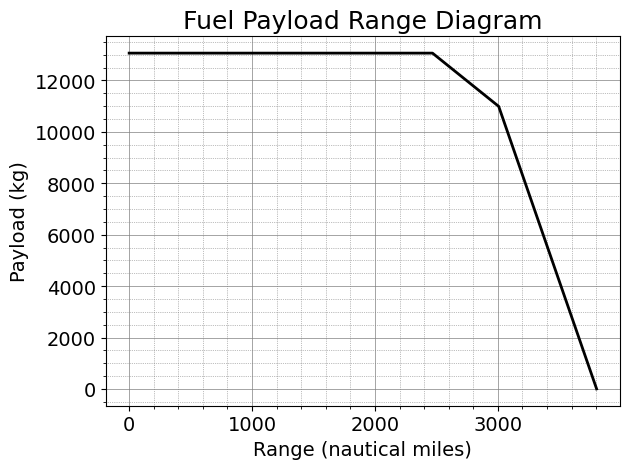

In [9]:
payload_range_results =  compute_payload_range_diagram(vehicle,assigned_propulsors,
                                                        weights_analysis=weights,
                                                        aerodynamics_analysis=aerodynamics,
                                                        cruise_airspeed=airspeed,
                                                        cruise_altitude=altitude, 
                                                        max_range_guess = max_range_guess)